<a href="https://colab.research.google.com/github/azganushpoghosyan/fidap/blob/main/Topics_analysis_of_HN_data_(July_August).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data, Introduction

Hacker News is a social news website focusing on computer science and entrepreneurship ([Wikipedia](https://en.wikipedia.org/wiki/Hacker_News)).
In this analysis we will try to understand what topics are discussed in HN in the last 30 days using texts of stories and comments in the platform. 

For this purpose we are going to use LDA (Latent Dirichlet Allocation) model. The idea of LDA is to learn the representation of a fixed number of topics, and given this number of topics learn the topic distribution that each document in a collection of documents has ([Linkedin](https://www.linkedin.com/pulse/lda-explanation-gaurhari-dass)).

First, let's instantiate api connection and import necesary libraries

In [ ]:
!pip install --upgrade fidap
!pip install pyLDAvis
!pip install chart_studio

from fidap import fidap_client
fidap = fidap_client(api_key=key)

import json
import requests
import pandas as pd
import numpy as np
import regex
import re
import string
from collections import Counter
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim_models
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls
import spacy
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

!spacy download en_core_web_lg

Next, let's import the data. We will use Fidap's ***Hacker News*** dataset (***full*** table).

In [ ]:
df = fidap.sql("""
SELECT text, type
FROM bigquery-public-data.hacker_news.full
WHERE type IN ('story', 'comment') AND CAST(LEFT(CAST(timestamp AS STRING), 10) AS DATE) >= CURRENT_DATE() - 30 AND text != ''
""")

Let's check the distribution of stories and comments in our text data. 

In [ ]:
df_agg = df.groupby('type').count().reset_index()
df_agg = df_agg.rename(columns = {'text': 'post_count'})
df_agg['percent'] = (df_agg['post_count'] / df_agg['post_count'].sum()) * 100

In [ ]:
df_agg.head()

,type,post_count,percent
0,comment,274546,99.541353
1,story,1265,0.458647


We see that comments' make ~99.5% of the text.

We are interested only in the text data, so, we'll remove the 'type' column.

In [ ]:
df = df.drop(['type'], axis = 1)

#Preprocessing

To create an LDA model or other text-related model, we first need to clean and preprocess the raw data. So, let's proceed to the step. 

First, let's remove all URLs, emails, punctuations, symbols and numbers from the text

In [ ]:
def clean_text(text):
  no_url = re.sub(r'http\S+', '', text)
  no_email = re.sub(r'\S*@\S*\s?', '', no_url)
  no_newline = re.sub(r'\s+', ' ', no_email)
  no_singlequotes = re.sub(r"\'", "", no_newline) 
  no_symbols = re.sub(r'[^\w]', ' ', no_singlequotes)
  no_numbers = re.sub(r'[0-9]', '', no_symbols)
  clean_text = no_numbers
  return clean_text
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
df.head()

,text,clean_text
0,"The Metaverse is just a mmo, except some of th...",The Metaverse is just a mmo except some of th...
1,Just gotta say: I was really expecting to not ...,Just gotta say I was really expecting to not ...
2,No. He&#x27;s saying that the GPA in college d...,No He x s saying that the GPA in college doe...
3,Yep - worked there for a few years on an iOS&#...,Yep worked there for a few years on an iOS ...
4,"Hahah, well, a couple of guys out there have h...",Hahah well a couple of guys out there have h...


We have the clearn text in a new column. The next steps are **Tokenization** and **Lemmatization** of the text. These steps assume:

*  breaking the text down into sentences/words 
*  removing stopwords (common words /words irrelevant for the modeling)
*  making all texts lowercase
*  removing words that have fewer than 3 characters
*  converting words into their root form in order to reduce the total number of unique words


In [ ]:
nlp = spacy.load('en_core_web_lg')
tokenizer = Tokenizer(nlp.vocab)
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@', 'href', 'thing']
stop_words = nlp.Defaults.stop_words.union(custom_stopwords).union(stopwords)
tokens = []
for doc in tokenizer.pipe(df['clean_text'], batch_size=500):
  doc_tokens = []    
  for token in doc:
    if token.text.lower() not in stop_words and:
      new_token = re.sub(r'\b\w{1,3}\b', '', token.text.lower())
      doc_tokens.append(new_token)   
  tokens.append(doc_tokens)
df['tokens'] = tokens

In [ ]:
df.head()

,text,clean_text,tokens
0,"The Metaverse is just a mmo, except some of th...",The Metaverse is just a mmo except some of th...,"[metaverse, , characters, real, world, paralle..."
1,Just gotta say: I was really expecting to not ...,Just gotta say I was really expecting to not ...,"[gotta, expecting, batched, format, actually, ..."
2,No. He&#x27;s saying that the GPA in college d...,No He x s saying that the GPA in college doe...,"[, , saying, , college, doesn, , , matter, ask..."
3,Yep - worked there for a few years on an iOS&#...,Yep worked there for a few years on an iOS ...,"[, , worked, years, , , , team, pretty, , wa..."
4,"Hahah, well, a couple of guys out there have h...",Hahah well a couple of guys out there have h...,"[hahah, couple, guys, hundreds, billions, doll..."


In [ ]:
def get_lemmas(text):
  lemmas = []
  doc = nlp(text)
  for token in doc:
    if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
      lemmas.append(token.lemma_)
  return lemmas
df['tokens_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]
df['lemmas'] = df['tokens_to_text'].apply(get_lemmas)
df = df.drop(['tokens_to_text'], axis = 1)

In [ ]:
df.head()

,text,clean_text,tokens,tokens_to_text,lemmas
0,"The Metaverse is just a mmo, except some of th...",The Metaverse is just a mmo except some of th...,"[metaverse, , characters, real, world, paralle...",metaverse characters real world parallel guy...,"[metaverse, , character, real, world, paralle..."
1,Just gotta say: I was really expecting to not ...,Just gotta say I was really expecting to not ...,"[gotta, expecting, batched, format, actually, ...",gotta expecting batched format actually kind okay,"[get, to, expect, batch, format, actually, kin..."
2,No. He&#x27;s saying that the GPA in college d...,No He x s saying that the GPA in college doe...,"[, , saying, , college, doesn, , , matter, ask...",saying college doesn matter asked teacher...,"[ , say, , college, doesn, , matter, ask, ..."
3,Yep - worked there for a few years on an iOS&#...,Yep worked there for a few years on an iOS ...,"[, , worked, years, , , , team, pretty, , wa...",worked years team pretty watch progres...,"[ , work, year, , team, pretty, , watch..."
4,"Hahah, well, a couple of guys out there have h...",Hahah well a couple of guys out there have h...,"[hahah, couple, guys, hundreds, billions, doll...",hahah couple guys hundreds billions dollars f...,"[hahah, couple, guy, hundred, billion, dollar,..."


In [ ]:
#final tokenization
def tokenize(text):
  
  tokens = re.sub('[^a-zA-Z 0-9]', '', text)
  tokens = re.sub('[%s]' % re.escape(string.punctuation), '', tokens) 
  tokens = tokens.lower().split() 
  return tokens

df['lemmas_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]
df['lemma_tokens'] = df['lemmas_to_text'].apply(tokenize)
df = df.drop(['lemmas_to_text'], axis = 1)

In [ ]:
df.head()

,text,clean_text,tokens,tokens_to_text,lemmas,lemmas_to_text,lemma_tokens
0,"The Metaverse is just a mmo, except some of th...",The Metaverse is just a mmo except some of th...,"[metaverse, , characters, real, world, paralle...",metaverse characters real world parallel guy...,"[metaverse, , character, real, world, paralle...",metaverse character real world parallel gu...,"[metaverse, character, real, world, parallel, ..."
1,Just gotta say: I was really expecting to not ...,Just gotta say I was really expecting to not ...,"[gotta, expecting, batched, format, actually, ...",gotta expecting batched format actually kind okay,"[get, to, expect, batch, format, actually, kin...",get to expect batch format actually kind okay,"[get, to, expect, batch, format, actually, kin..."
2,No. He&#x27;s saying that the GPA in college d...,No He x s saying that the GPA in college doe...,"[, , saying, , college, doesn, , , matter, ask...",saying college doesn matter asked teacher...,"[ , say, , college, doesn, , matter, ask, ...",say college doesn matter ask teacher r...,"[say, college, doesn, matter, ask, teacher, ra..."
3,Yep - worked there for a few years on an iOS&#...,Yep worked there for a few years on an iOS ...,"[, , worked, years, , , , team, pretty, , wa...",worked years team pretty watch progres...,"[ , work, year, , team, pretty, , watch...",work year team pretty watch progres...,"[work, year, team, pretty, watch, progression,..."
4,"Hahah, well, a couple of guys out there have h...",Hahah well a couple of guys out there have h...,"[hahah, couple, guys, hundreds, billions, doll...",hahah couple guys hundreds billions dollars f...,"[hahah, couple, guy, hundred, billion, dollar,...",hahah couple guy hundred billion dollar feve...,"[hahah, couple, guy, hundred, billion, dollar,..."


We will use the final column 'lemma_tokens' for modeling, so let's have this data in a separate doc

In [ ]:
processed_docs = df['lemma_tokens']

#Model

To create an LDA model instance we need to provide a disctionary and a document word matrix as inputs. Documents in our case are individual texts. So, let's create those inputs for the model. 

In [ ]:
#create a dictionary and filter extreme cases 
id2word = Dictionary(processed_docs)
id2word.filter_extremes(no_below=2, no_above=.99)

#create a corpus object as a document word matrix
corpus = [id2word.doc2bow(d) for d in processed_docs]

Now we can instantiate a base LDA model, we will choose 5 topics for the initial model

In [ ]:
base_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=5, 
                                             random_state=100,
                                             update_every=1,
                                             chunksize=100,
                                             passes=10,
                                             alpha='auto',
                                             per_word_topics=True)

In [ ]:
#get and print the topics from the model
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]
topics = [' '.join(t[0:10]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
year money live power high container house energy area sell

------ Topic 1 ------
nofollow user apple datum device google open search service market

------ Topic 2 ------
quot think know point say mean find doesn good read

------ Topic 3 ------
people go company change get world maybe right happen life

------ Topic 4 ------
work time need code problem system game build look good



We can associate the words with some topics, however, the inference is not very clear. A possible problem can be a non-optimal number of topics. 

Let's also print the coherence score of the model based on which we will evaluate it.

In [ ]:
coherence_model = CoherenceModel(model=base_model, texts=processed_docs, 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Coherence Score:  0.4991142141194952


It's not very low for an LDA model, however, it can be higher.

#Find the best model

We will find the best model by building many LDA models with different number of topics and then choosing the one with the highest coherence score

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
  coherence_values_topic = []
  model_list_topic = []
  for num_topics in range(start, limit, step):
    model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
    model_list_topic.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values_topic.append(coherencemodel.get_coherence())

  return model_list_topic, coherence_values_topic

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_docs, start=2, limit=40, step=6)

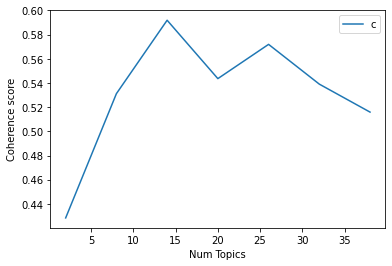

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4284
Num Topics = 8  has Coherence Value of 0.5311
Num Topics = 14  has Coherence Value of 0.5919
Num Topics = 20  has Coherence Value of 0.5436
Num Topics = 26  has Coherence Value of 0.5719
Num Topics = 32  has Coherence Value of 0.539
Num Topics = 38  has Coherence Value of 0.5159


We can see that the model with 14 number of topics has the highest coherence value: 0.5919. So, we will choose this model as the most optimal one.

In [ ]:
optimal_model = model_list[2]
coherence_model_optimal = CoherenceModel(model=optimal_model, texts=processed_docs, 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_optimal = coherence_model_optimal.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_optimal)


Coherence Score:  0.5918712438914245


Let's print the topics and the top 10 words related to each one.

In [ ]:
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.017*"school" + 0.015*"year" + 0.015*"life" + 0.012*"kid" + 0.011*"class" '
  '+ 0.010*"high" + 0.010*"student" + 0.007*"good" + 0.006*"parent" + '
  '0.006*"live"'),
 (1,
  '0.009*"live" + 0.009*"energy" + 0.009*"country" + 0.008*"power" + '
  '0.008*"city" + 0.007*"year" + 0.007*"need" + 0.007*"area" + 0.007*"water" + '
  '0.007*"change"'),
 (2,
  '0.027*"apple" + 0.014*"user" + 0.012*"security" + 0.011*"device" + '
  '0.011*"privacy" + 0.011*"service" + 0.010*"datum" + 0.009*"access" + '
  '0.008*"server" + 0.008*"system"'),
 (3,
  '0.020*"money" + 0.014*"cost" + 0.014*"market" + 0.012*"price" + '
  '0.009*"value" + 0.008*"year" + 0.008*"sell" + 0.008*"pay" + '
  '0.008*"business" + 0.008*"people"'),
 (4,
  '0.012*"work" + 0.012*"user" + 0.010*"support" + 0.010*"phone" + '
  '0.010*"linux" + 0.010*"open" + 0.010*"browser" + 0.009*"window" + '
  '0.009*"google" + 0.009*"app"'),
 (5,
  '0.025*"code" + 0.009*"language" + 0.009*"write" + 0.009*"need" + '
  '0.009*"system" + 0.0

#Visualization

Finally, let's explore the topics and their associated words using pyLDAviz package

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.010486 -0.023907       1        1  12.768989
9     -0.044938 -0.011288       2        1  12.086795
5     -0.000353  0.074904       3        1  10.965613
3      0.135683  0.029284       4        1   8.043500
1      0.157255 -0.059766       5        1   7.846978
13    -0.197492 -0.064876       6        1   6.608854
4      0.041563  0.138538       7        1   6.468766
2     -0.015332  0.267341       8        1   6.386059
12     0.167192  0.053414       9        1   6.102402
11    -0.233958  0.043804      10        1   5.210792
7     -0.084156 -0.026909      11        1   4.933499
6      0.154772 -0.076354      12        1   4.519206
10    -0.145543 -0.122800      13        1   4.303078
0      0.075793 -0.221387      14        1   3.755467, topic_info=          Term           Freq          Total Category  logprob  loglift
262       quot  166376.000000  166376.000000  Default  30.0000  30.0000
544   nofollow   44587.000000   44587.000000  Default  29.0000  29.0000
61        work   45897.000000   45897.000000  Default  28.0000  28.0000
416       code   19474.000000   19474.000000  Default  27.0000  27.0000
160     people   67938.000000   67938.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
3244   program     915.903207    5346.555284  Topic14  -5.6743   1.5177
132      think    1124.252098   46932.457842  Topic14  -5.4693  -0.4496
76        time     996.488382   38344.759926  Topic14  -5.5900  -0.3682
160     people     919.664665   67938.619356  Topic14  -5.6702  -1.0204
496      great     853.122034   11654.680930  Topic14  -5.7453   0.6674

[1084 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3860      3  0.989333  abstraction
3860      6  0.008994  abstraction
410       1  0.097513        abuse
410       2  0.327628        abuse
410       8  0.214971        abuse
...     ...       ...          ...
2484      6  0.000510        young
2484      9  0.002040        young
2484     11  0.007141        young
2484     12  0.000510        young
2484     14  0.684537        young

[4326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 6, 4, 2, 14, 5, 3, 13, 12, 8, 7, 11, 1])

# ***Possible topics we can infer are:***


> **School** (school, kid, class, high, student...)


> **Resources** (energy, water, power, city...)


> **Coding** (code, language, write, tool, problem...)


> **Technical support** (app, support, user, linux, windows, browser...)


> **Market** (money, cost, business, market, price, value, sell...)


> **Covid** (people, vaccine, covid, country, case...)


> **Learning** (book, learn, read, know, word...)


> **Software company** (work, company, software, team, product, employee, remote...)















